<a href="https://colab.research.google.com/github/G-Assimila/pvlncc2025/blob/main/notebooks/DataAssimilation_SC_OI_AC_KF(Python).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Assimilation:
(1) Successive correction;
(2) Optimal Interpolation;
(3) Analysis Correction;
(4) Kalman Filter.

# **Load packages**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# **0 - Program's brief description**

In [2]:
# Program to perform data assimilation on the
# Lorenz equations
#
#
#  (c) 2002  Data Assimilation Research Centre
#
#  Original program by Matthew Martin
#
#  Change history:
#      Changes to make code more robust and add further options
#                       (Amos Lawless)
#      23/01/03 Change to position windows correctly for any screen
#               resolution (Amos Lawless)
#      16/07/04 Change to initial conditions and run time
#
#  Structure of program:
#    1. Inputs
#    2. `True' solution
#    3. Background solution
#    4. Observations
#    5. Covariance matrices
#    6. Assimilation
#    7. Plot results.
#
#  List of main variables
#    h:          Time step for Runge-Kutta scheme
#    s:          sigma coefficient in equations
#    r:          rho coefficient in equations
#    b:          beta coefficient in equations
#
#    fmax:       Total time of assimilation + forecast
#    ob_f:       Frequency of observations in time steps
#    q:          x-axis data values for plots
#    sd:         Variance of observation error
#    tmax:       Total time of assimilation
#
#    R(3,3):     Observation error covariance matrix
#    B(3,3):     Background error covariance matrix
#    Qx(3,3,fmax): Model error covariance matrix for Kalman Filter
#                  (default constant in time)
#
#    x(fmax,1), y(fmax,1), z(fmax,1):
#                True state vectors of x,y,z
#    xb(fmax,1), yb(fmax,1), zb(fmax,1):
#                Background state vectors of x,y,z
#    xob(tmax), yob(tmax), zob(tmax)
#                Observations of x,y,z
#
#    x_ob(3,tmax): [xob';yob';zob']
#    x_sc(3,fmax): Analysis and forecast from SC scheme, with first
#                  index representing x, y or z variable
#    x_ac(3,fmax): Analysis and forecast from AC scheme, with first
#                  index representing x, y or z variable
#    x_oi(3,fmax): Analysis and forecast from OI scheme, with first
#                  index representing x, y or z variable
#    x_kf(3,fmax): Analysis and forecast from Kalman Filter, with first
#                  index representing x, y or z variable

# **1. Inputs**

In [3]:
#---------------------------------------------------------------------
# 1.  INPUTS
#---------------------------------------------------------------------

In [4]:
# @title
#----- Please choose an assimilation scheme -----
#      1) Successive correction
#      2) Optimal Interpolation
#      3) Analysis Correction
#      4) Kalman Filter
#      Select a menu number:
l_assim = 2
l_assim -= 1

n_its = 0
l_weight = 0

if l_assim == 0 or l_assim == 2:
    #----- How many iterations? -----
    #      1
    #      2
    #      3
    #      4
    #      5
    n_its = 4

if l_assim != 0:
    #----- Use correct weighting matrices? -----
    #      1) No
    #      2) Yes
    l_weight = 2
    l_weight -= 1

fmax = 1000  # time of assimilation + forecast
q = np.arange(0, fmax * 0.01, 0.01)

# **2. "True" solution**

In [5]:
#-------------------------------------------------------------------------
# 2.  TRUE SOLUTION
#-------------------------------------------------------------------------

### True solution of lorenz equations using 2nd order Runge-Kutta method

In [6]:
# True solution of lorenz equations using 2nd order Runge-Kutta method
x = np.zeros(fmax)
y = np.zeros(fmax)
z = np.zeros(fmax)

### Parameters

In [7]:
# Parameters
h = 0.01  # Time step for Runge-Kutta scheme
s = 10.0  # Sigma
r = 28.0  # Rho
b = 8.0 / 3.0  # Beta

### Initial contidions

In [8]:
# Initial contidions
x[0] = -5.4458
y[0] = -5.4841
z[0] = 22.5606

# Loop to calculate the solution using the second-order Runge-Kutta method
for i in range(fmax - 1):
    k1x = s * y[i] - s * x[i]
    k1y = r * x[i] - y[i] - x[i] * z[i]
    k1z = x[i] * y[i] - b * z[i]

    k2x = s * (y[i] + h * k1y) - s * (x[i] + h * k1x)
    k2y = r * (x[i] + h * k1x) - (y[i] + h * k1y) - (x[i] + h * k1x) * (z[i] + h * k1z)
    k2z = (x[i] + h * k1x) * (y[i] + h * k1y) - b * (z[i] + h * k1z)

    x[i + 1] = x[i] + 0.5 * h * (k1x + k2x)
    y[i + 1] = y[i] + 0.5 * h * (k1y + k2y)
    z[i + 1] = z[i] + 0.5 * h * (k1z + k2z)

print('Done true solution')

Done true solution


### Plot true solution of x

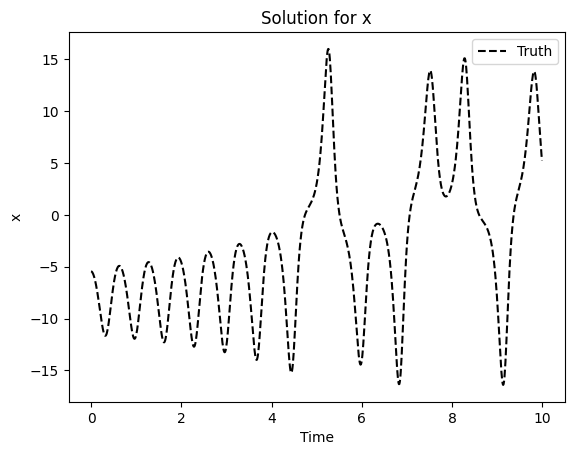

In [9]:
# Assuming q and x are already defined
# q = ... (array of time values)
# x = ... (array of x values corresponding to time q)

# Plot true solution of x
plt.figure(1)
plt.clf()
plt.plot(q, x, 'k--')
plt.legend(["Truth"])
plt.xlabel("Time")
plt.ylabel("x")
plt.title("Solution for x")
plt.show()  # This will display the plot

### Plot true solution of z

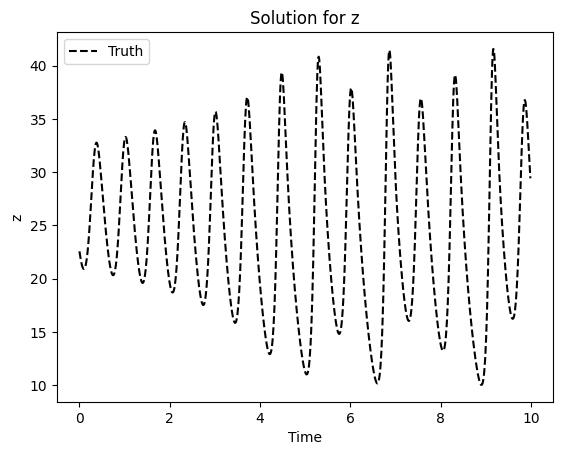

In [10]:
# Assuming q and z are already defined
# q = ... (array of time values)
# z = ... (array of z values corresponding to time q)

# Plot true solution of z
plt.figure(2)
plt.clf()
plt.plot(q, z, 'k--')
plt.legend(["Truth"])
plt.xlabel("Time")
plt.ylabel("z")
plt.title("Solution for z")
plt.show()  # This will display the plot

# **3. Background solution**

In [11]:
#-----------------------------------------------------------------------------------
# 3.  BACKGROUND SOLUTION
#-----------------------------------------------------------------------------------

### Produce a background solution which starts from some perturbed initial conditions

In [12]:
# Produce a background solution which starts from some perturbed initial conditions
xb = np.zeros(fmax)
yb = np.zeros(fmax)
zb = np.zeros(fmax)

### Background solution initial condition

In [13]:
#Background solution initial conditions

#bg_noise=randn(3,1);
#xb(1)=x(1)+bg_noise(1)*2.0d0;
#yb(1)=y(1)+bg_noise(2)*2.0d0;
#zb(1)=z(1)+bg_noise(3)*2.0d0;

xb[0] = -5.9
yb[0] = -5.0
zb[0] = 24.0

### Loop over time

In [14]:
# Inicializando arrays k1 e k2
k1xb = np.zeros(fmax)
k1yb = np.zeros(fmax)
k1zb = np.zeros(fmax)
k2xb = np.zeros(fmax)
k2yb = np.zeros(fmax)
k2zb = np.zeros(fmax)

# Loop sobre o tempo
for i in range(fmax - 1):
    k1xb[i] = s * yb[i] - s * xb[i]
    k1yb[i] = r * xb[i] - yb[i] - xb[i] * zb[i]
    k1zb[i] = xb[i] * yb[i] - b * zb[i]

    k2xb[i] = s * (yb[i] + h * k1yb[i]) - s * (xb[i] + h * k1xb[i])
    k2yb[i] = r * (xb[i] + h * k1xb[i]) - (yb[i] + h * k1yb[i]) - (xb[i] + h * k1xb[i]) * (zb[i] + h * k1zb[i])
    k2zb[i] = (xb[i] + h * k1xb[i]) * (yb[i] + h * k1yb[i]) - b * (zb[i] + h * k1zb[i])

    xb[i + 1] = xb[i] + 0.5 * h * (k1xb[i] + k2xb[i])
    yb[i + 1] = yb[i] + 0.5 * h * (k1yb[i] + k2yb[i])
    zb[i + 1] = zb[i] + 0.5 * h * (k1zb[i] + k2zb[i])

print('Done background solution')

Done background solution


### Plot background solution of x

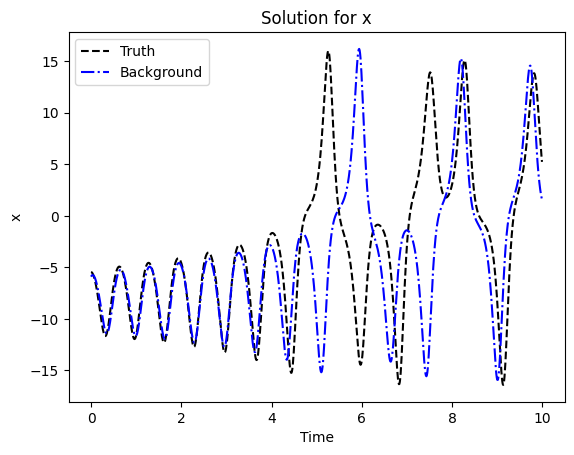

In [15]:
# Plot background solution
plt.figure(1)
plt.clf()
plt.plot(q, x, 'k--', label='Truth')
plt.plot(q, xb, 'b-.', label='Background')
plt.legend()
plt.xlabel("Time")
plt.ylabel("x")
plt.title("Solution for x")
plt.show()

### Plot background solution of z

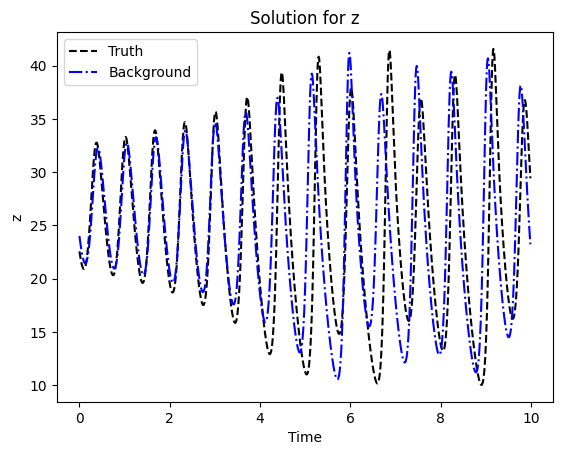

In [16]:
# Plot background solution for z
plt.figure(2)
plt.clf()
plt.plot(q, z, 'k--', label='Truth')
plt.plot(q, zb, 'b-.', label='Background')
plt.legend()
plt.xlabel("Time")
plt.ylabel("z")
plt.title("Solution for z")
plt.show()

# **4. Observations**

In [17]:
#-----------------------------------------------------------------------------------
# 4.  OBSERVATIONS
#-----------------------------------------------------------------------------------

### Choose number of time steps between observations

In [18]:
#----- How many time steps between observations? -----
#      25
#      50
#      100
#      200
ob_f = 25

#----- Noise on observations? -----
#      1) No
#      2) Yes
# Select a menu number:
l_noise = 2
l_noise -= 1
tmax = 600 + ob_f  # time of assimilation (assimilation window)

### The observations are calculated from the true solution at certain points with noise added

In [19]:
# The observations are calculated from the true solution at certain
# points with noise added.

xob = np.zeros(tmax)
yob = np.zeros(tmax)
zob = np.zeros(tmax)

nobs = tmax // ob_f  # number of observations
vec = np.arange(1, tmax + 1, ob_f)

if l_noise == 1:
    l_read_noise = 1
    l_read_noise -= 1
    if l_read_noise == 0:
        sc_x_noise = np.random.randn(nobs)
        sc_y_noise = np.random.randn(nobs)
        sc_z_noise = np.random.randn(nobs)
        # Fixed values for test
        #sc_x_noise = np.array([ 0.8219025 ,  0.08704707, -0.29900735,  0.09176078, -1.98756891, -0.21967189,
        #                 0.35711257,  1.47789404, -0.51827022, -0.8084936 , -0.50175704,  0.91540212,
        #                 0.32875111, -0.5297602 ,  0.51326743,  0.09707755,  0.96864499, -0.70205309,
        #                -0.32766215, -0.39210815, -1.46351495,  0.29612028,  0.26105527,  0.00511346,
        #                -0.23458713])
        #sc_y_noise = np.array([-1.41537074, -0.42064532, -0.34271452, -0.80227727, -0.16128571,  0.40405086,
        #                1.8861859 ,  0.17457781,  0.25755039, -0.07444592, -1.91877122, -0.02651388,
        #                0.06023021,  2.46324211, -0.19236096,  0.30154734, -0.03471177, -1.16867804,
        #                1.14282281,  0.75193303,  0.79103195, -0.90938745,  1.40279431, -1.40185106,
        #                0.58685709])
        #sc_z_noise = np.array([ 2.19045563, -0.99053633, -0.56629773,  0.09965137, -0.50347565, -1.55066343,
        #                 0.06856297, -1.06230371,  0.47359243, -0.91942423,  1.54993441, -0.78325329,
        #                -0.32206152,  0.81351722, -1.23086432,  0.22745993,  1.30714275, -1.60748323,
        #                 0.18463386,  0.25988279,  0.78182287, -1.23695071, -1.32045661,  0.52194157,
        #                 0.29698467])
        np.savez('noise.npz', sc_x_noise=sc_x_noise, sc_y_noise=sc_y_noise, sc_z_noise=sc_z_noise)
    elif l_read_noise == 1:
        noise_data = np.load('noise.npz')
        sc_x_noise = noise_data['sc_x_noise']
        sc_y_noise = noise_data['sc_y_noise']
        sc_z_noise = noise_data['sc_z_noise']
    else:
        raise ValueError('Invalid input')
    sd = 0.1
    var = np.sqrt(sd)
    RX = var * sc_x_noise
    RY = var * sc_y_noise
    RZ = var * sc_z_noise
else:
    RX = np.zeros(nobs)
    RY = np.zeros(nobs)
    RZ = np.zeros(nobs)

j = 0
for i in vec:
    xob[i - 1] = x[i - 1] + RX[j]
    yob[i - 1] = y[i - 1] + RY[j]
    zob[i - 1] = z[i - 1] + RZ[j]
    j += 1

print('Done observations')

Done observations


### Plot observations of x

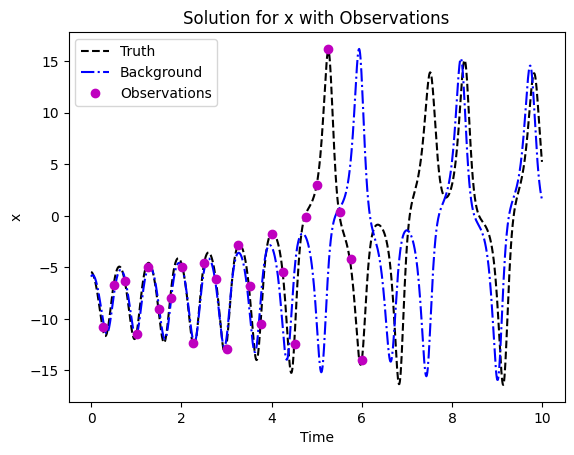

In [20]:
v = 0.01 * vec

# Plot x observations
plt.figure(1)
plt.clf()
plt.plot(q, x, 'k--', label='Truth')
plt.plot(q, xb, 'b-.', label='Background')
plt.plot(v[1:], xob[vec[1:] - 1], 'om', label='Observations')
plt.legend()
plt.xlabel("Time")
plt.ylabel("x")
plt.title("Solution for x with Observations")
plt.show()

### Plot observations of z

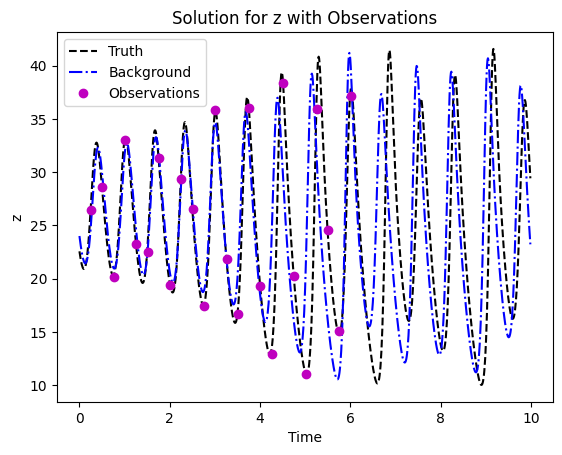

In [21]:
v = 0.01 * vec

# Plot z observations
plt.figure(2)
plt.clf()
plt.plot(q, z, 'k--', label='Truth')
plt.plot(q, zb, 'b-.', label='Background')
plt.plot(v[1:], zob[vec[1:] - 1], 'om', label='Observations')
plt.legend()
plt.xlabel("Time")
plt.ylabel("z")
plt.title("Solution for z with Observations")
plt.show()

# **5. Covariance matrices**

In [22]:
#-----------------------------------------------------------------------------------
# 5.  ERROR COVARIANCE MATRICES
#-----------------------------------------------------------------------------------

In [23]:
if l_assim != 0:

    BX = np.zeros((3, 3))
    BXi = np.zeros((3, 3, tmax))
    R = np.zeros((3, 3))
    Ri = np.zeros((3, 3, nobs)) # 3x3x13

    # Observation error covariance matrix, R.
    # Calculated to be the average errors over time between
    # the observations and true solution at the observation points.
    R = np.zeros((3, 3))

    # enumerate() => mapear os elementos de vec para os índices de Ri
    for idx, i in enumerate(vec):
        #print(idx, i)
        Ri[0, 0, idx] = (x[i-1] - xob[i-1]) * (x[i-1] - xob[i-1])
        Ri[0, 1, idx] = (x[i-1] - xob[i-1]) * (y[i-1] - yob[i-1])
        Ri[0, 2, idx] = (x[i-1] - xob[i-1]) * (z[i-1] - zob[i-1])
        Ri[1, 0, idx] = (y[i-1] - yob[i-1]) * (x[i-1] - xob[i-1])
        Ri[1, 1, idx] = (y[i-1] - yob[i-1]) * (y[i-1] - yob[i-1])
        Ri[1, 2, idx] = (y[i-1] - yob[i-1]) * (z[i-1] - zob[i-1])
        Ri[2, 0, idx] = (z[i-1] - zob[i-1]) * (x[i-1] - xob[i-1])
        Ri[2, 1, idx] = (z[i-1] - zob[i-1]) * (y[i-1] - yob[i-1])
        Ri[2, 2, idx] = (z[i-1] - zob[i-1]) * (z[i-1] - zob[i-1])

    if l_weight == 1:
        Rj = np.zeros((3, 3, nobs)) # 3x3x13
        #print("nobs:",nobs)
        #print("vec:",vec)
        #print("vec:",vec.shape)
        #print("Ri:",Ri.shape)
        #print("Rj:",Rj.shape)

        for j in range(3):
            for k in range(3):
                Rj[j, k, :] = Ri[j, k, :]
                R[j, k] = (1 / nobs) * np.sum(Rj[j, k, :])
    else:
        R = np.eye(3)  # Set to identity matrix for l_weight==0

    # Background error covariance matrix.
    # Calculated to be the average errors over time between the
    # background and true solutions.
    B = np.zeros((3, 3))
    if l_weight == 1:
        for i in range(tmax):
            BXi[0, 0, i] = (x[i] - xb[i]) * (x[i] - xb[i])
            BXi[0, 1, i] = (x[i] - xb[i]) * (y[i] - yb[i])
            BXi[0, 2, i] = (x[i] - xb[i]) * (z[i] - zb[i])
            BXi[1, 0, i] = (y[i] - yb[i]) * (x[i] - xb[i])
            BXi[1, 1, i] = (y[i] - yb[i]) * (y[i] - yb[i])
            BXi[1, 2, i] = (y[i] - yb[i]) * (z[i] - zb[i])
            BXi[2, 0, i] = (z[i] - zb[i]) * (x[i] - xb[i])
            BXi[2, 1, i] = (z[i] - zb[i]) * (y[i] - yb[i])
            BXi[2, 2, i] = (z[i] - zb[i]) * (z[i] - zb[i])
        for j in range(3):
            for k in range(3):
                BX[j, k] = (1 / tmax) * np.sum(BXi[j, k, :])
    else:
        BX = np.eye(3)  # Set to identity matrix for l_weight==0

# End of l_assim!=0 check

# **6. Data Assimilation**

In [24]:
#-----------------------------------------------------------------------------------
# 6.  DATA ASSIMILATION
#-----------------------------------------------------------------------------------

### 1) Successive correction

In [25]:
#####-#####-#####  SUCCESSIVE CORRECTIONS  #####-#####-#####

#    fmax:       Total time of assimilation + forecast
#    tmax:       Total time of assimilation

# fmax: 1000
# tmax: 625

if l_assim == 0:
    print('Performing successive correction analysis')
    assim_str = 'Successive correction'

    x_ob = np.zeros((3, fmax))
    x_sc = np.zeros((3, fmax))
    WX = 0.5 * np.eye(3)

    # Forecast at the initial time is the background
    xfc = np.zeros(fmax)
    yfc = np.zeros(fmax)
    zfc = np.zeros(fmax)

    # set forecast at i=1 to be the background guess there
    xfc[0] = xb[0]
    yfc[0] = yb[0]
    zfc[0] = zb[0]

    # put obs into one array
    #x_ob = np.vstack([xob, yob, zob]) # Bug
    x_ob[0, :625] = xob
    x_ob[1, :625] = yob
    x_ob[2, :625] = zob

    # put forecast values into one array
    x_sc[:, 0] = np.array([xb[0], yb[0], zb[0]])

    k1xfc = np.zeros(fmax)
    k1yfc = np.zeros(fmax)
    k1zfc = np.zeros(fmax)
    k2xfc = np.zeros(fmax)
    k2yfc = np.zeros(fmax)
    k2zfc = np.zeros(fmax)

    # Loop over time
    for i in range(fmax - 1):
        if i >= tmax:
            x_ob[:, i + 1] = 0

        # Forecast to time step i+1
        xfc[i] = x_sc[0, i]
        yfc[i] = x_sc[1, i]
        zfc[i] = x_sc[2, i]

        k1xfc[i] = s * yfc[i] - s * xfc[i]
        k1yfc[i] = r * xfc[i] - yfc[i] - xfc[i] * zfc[i]
        k1zfc[i] = xfc[i] * yfc[i] - b * zfc[i]

        k2xfc[i] = s * (yfc[i] + h * k1yfc[i]) - s * (xfc[i] + h * k1xfc[i])
        k2yfc[i] = (r * (xfc[i] + h * k1xfc[i]) - (yfc[i] + h * k1yfc[i]) - (xfc[i] + h * k1xfc[i]) * (zfc[i] + h * k1zfc[i]))
        k2zfc[i] = (xfc[i] + h * k1xfc[i]) * (yfc[i] + h * k1yfc[i]) - b * (zfc[i] + h * k1zfc[i])

        xfc[i + 1] = xfc[i] + 0.5 * h * (k1xfc[i] + k2xfc[i])
        yfc[i + 1] = yfc[i] + 0.5 * h * (k1yfc[i] + k2yfc[i])
        zfc[i + 1] = zfc[i] + 0.5 * h * (k1zfc[i] + k2zfc[i])

        # If there is an observation, produce an analysis
        if not np.all(x_ob[:, i + 1] == 0):
            x_sc[:, i + 1] = np.array([xfc[i + 1], yfc[i + 1], zfc[i + 1]])
            for _ in range(n_its):
                x_sc[:, i + 1] += WX @ (x_ob[:, i + 1] - x_sc[:, i + 1])
        else:
            x_sc[:, i + 1] = np.array([xfc[i + 1], yfc[i + 1], zfc[i + 1]])


### 2) Optimal Interpolation

In [26]:
#####-#####-#####  OPTIMAL INTERPOLATION  #####-#####-#####

#    fmax:       Total time of assimilation + forecast
#    tmax:       Total time of assimilation

# fmax: 1000
# tmax: 625

if l_assim == 1:
    print('Performing OI analysis')
    assim_str = 'Optimal interpolation'

    x_ob = np.zeros((3, fmax))
    x_oi = np.zeros((3, fmax))
    WX = np.zeros((3, 3))

    # state weighting matrix
    WX = BX @ np.linalg.pinv(BX + R)

    # Forecast at the initial time is the background
    xfc = np.zeros(fmax)
    yfc = np.zeros(fmax)
    zfc = np.zeros(fmax)

    # set forecast at i=1 to be the background guess there
    xfc[0] = xb[0]
    yfc[0] = yb[0]
    zfc[0] = zb[0]

    # put obs into one array
    #x_ob = np.vstack([xob, yob, zob]) # Bug
    x_ob[0, :625] = xob
    x_ob[1, :625] = yob
    x_ob[2, :625] = zob

    # put forecast values into one array
    x_oi[:, 0] = np.array([xb[0], yb[0], zb[0]])

    k1xfc = np.zeros(fmax)
    k1yfc = np.zeros(fmax)
    k1zfc = np.zeros(fmax)
    k2xfc = np.zeros(fmax)
    k2yfc = np.zeros(fmax)
    k2zfc = np.zeros(fmax)

    # Start loop over time
    for i in range(fmax - 1):
        if i >= tmax:
            x_ob[:, i + 1] = 0

        # Forecast to time step i+1
        xfc[i] = x_oi[0, i]
        yfc[i] = x_oi[1, i]
        zfc[i] = x_oi[2, i]

        k1xfc[i] = s * yfc[i] - s * xfc[i]
        k1yfc[i] = r * xfc[i] - yfc[i] - xfc[i] * zfc[i]
        k1zfc[i] = xfc[i] * yfc[i] - b * zfc[i]

        k2xfc[i] = s * (yfc[i] + h * k1yfc[i]) - s * (xfc[i] + h * k1xfc[i])
        k2yfc[i] = r * (xfc[i] + h * k1xfc[i]) - (yfc[i] + h * k1yfc[i]) - (xfc[i] + h * k1xfc[i]) * (zfc[i] + h * k1zfc[i])
        k2zfc[i] = (xfc[i] + h * k1xfc[i]) * (yfc[i] + h * k1yfc[i]) - b * (zfc[i] + h * k1zfc[i])

        xfc[i + 1] = xfc[i] + 0.5 * h * (k1xfc[i] + k2xfc[i])
        yfc[i + 1] = yfc[i] + 0.5 * h * (k1yfc[i] + k2yfc[i])
        zfc[i + 1] = zfc[i] + 0.5 * h * (k1zfc[i] + k2zfc[i])

        # If there is an observation, produce analysis
        if not np.all(x_ob[:, i + 1] == 0):
            x_oi[:, i + 1] = np.array([xfc[i + 1], yfc[i + 1], zfc[i + 1]])
            x_oi[:, i + 1] += WX @ (x_ob[:, i + 1] - x_oi[:, i + 1])
        else:
            x_oi[:, i + 1] = np.array([xfc[i + 1], yfc[i + 1], zfc[i + 1]])


Performing OI analysis


### 3) Analysis Correction

In [27]:
#####-#####-#####  ANALYSIS CORRECTION  #####-#####-#####

#    fmax:       Total time of assimilation + forecast
#    tmax:       Total time of assimilation

# fmax: 1000
# tmax: 625

if l_assim == 2:
    print('Performing AC analysis')
    assim_str = 'Analysis correction'

    if l_noise == 0:
        R = np.eye(3)

    x_ob = np.zeros((3, fmax))
    x_ac = np.zeros((3, fmax))
    y_ac = np.zeros((3, fmax))

    WX = np.zeros((3, 3))  # =BX*R^-1
    QX = np.zeros((3, 3))  # =(WX+I)^-1

    xfc[0] = xb[0]
    yfc[0] = yb[0]
    zfc[0] = zb[0]

    # state weighting matrix
    WX = np.dot(BX, np.linalg.pinv(R))
    QX = np.linalg.pinv(WX + np.eye(3))

    #x_ob = np.array([xob, yob, zob]) # Bug
    x_ob[0, :625] = xob
    x_ob[1, :625] = yob
    x_ob[2, :625] = zob
    x_ac[:, 0] = np.array([xb[0], yb[0], zb[0]])
    y_ac[:, 0] = x_ob[:, 0]

    # Start loop over time
    for i in range(fmax - 1):
        if i >= tmax:
            x_ob[:, i + 1] = 0

        # Forecast to time step i+1
        xfc[i] = x_ac[0, i]
        yfc[i] = x_ac[1, i]
        zfc[i] = x_ac[2, i]

        k1xfc = s * yfc[i] - s * xfc[i]
        k1yfc = r * xfc[i] - yfc[i] - xfc[i] * zfc[i]
        k1zfc = xfc[i] * yfc[i] - b * zfc[i]

        k2xfc = s * (yfc[i] + h * k1yfc) - s * (xfc[i] + h * k1xfc)
        k2yfc = r * (xfc[i] + h * k1xfc) - (yfc[i] + h * k1yfc) - (xfc[i] + h * k1xfc) * (zfc[i] + h * k1zfc)
        k2zfc = (xfc[i] + h * k1xfc) * (yfc[i] + h * k1yfc) - b * (zfc[i] + h * k1zfc)

        xfc[i + 1] = xfc[i] + 0.5 * h * (k1xfc + k2xfc)
        yfc[i + 1] = yfc[i] + 0.5 * h * (k1yfc + k2yfc)
        zfc[i + 1] = zfc[i] + 0.5 * h * (k1zfc + k2zfc)

        # If there is an observation then produce an analysis
        if not np.all(x_ob[:, i + 1] == 0):
            x_ac[:, i + 1] = np.array([xfc[i + 1], yfc[i + 1], zfc[i + 1]])
            y_ac[:, i + 1] = x_ob[:, i + 1]

            for j in range(n_its):
                x_ac[:, i + 1] = x_ac[:, i + 1] + np.dot(WX, np.dot(QX, (y_ac[:, i + 1] - x_ac[:, i + 1])))
                y_ac[:, i + 1] = y_ac[:, i + 1] - np.dot(QX, (y_ac[:, i + 1] - x_ac[:, i + 1]))
        else:
            x_ac[:, i + 1] = np.array([xfc[i + 1], yfc[i + 1], zfc[i + 1]])
    # End loop over time

### 4) Kalman Filter

In [28]:
#####-#####-#####  KALMAN FILTER  #####-#####-#####

#    fmax:       Total time of assimilation + forecast
#    tmax:       Total time of assimilation

# fmax: 1000
# tmax: 625

if l_assim == 3:
    print('Performing kalman filter analysis')
    assim_str = 'Kalman filter'

    KX = np.zeros((3, 3, fmax))
    Pfx = np.zeros((3, 3, fmax))
    Pax = np.zeros((3, 3, fmax))
    xfc = np.zeros(fmax)
    yfc = np.zeros(fmax)
    zfc = np.zeros(fmax)
    x_kf = np.zeros((3, fmax))
    x_fc = np.zeros((3, fmax))
    x_ob = np.zeros((3, fmax))
    Mx = np.zeros((3, 3, fmax))
    Qx = np.zeros((3, 3, fmax))

    # put obs into one array
    x_ob[0, :625] = xob
    x_ob[1, :625] = yob
    x_ob[2, :625] = zob

    # set forecast at i=1 to be the background guess there
    xfc[0] = xb[0]
    yfc[0] = yb[0]
    zfc[0] = zb[0]

    # put forecast values into one array
    x_fc[:, 0] = np.array([xb[0], yb[0], zb[0]])

    if l_weight == 1:
        # forecast error covariance at i=1 is the background error covariance there
        Pfx[:, :, 0] = BXi[:, :, 0]
    else:
        # begin with some incorrect guess
        Pfx[:, :, 0] = np.eye(3)

    # calculate the gain matrix at i=1
    KX[:, :, 0] = np.dot(Pfx[:, :, 0], np.linalg.pinv(Pfx[:, :, 0] + Ri[:, :, 0]))

    x_kf[:, 0] = x_fc[:, 0]

    # calculate analysis error covariance matrix at i=1
    Pax[:, :, 0] = (np.eye(3) - KX[:, :, 0]) @ Pfx[:, :, 0]


    for i in range(fmax - 1):
        if i >= tmax:
            x_ob[:, i + 1] = 0

        xfc[i] = x_kf[0, i]
        yfc[i] = x_kf[1, i]
        zfc[i] = x_kf[2, i]

        # tangent-linear model - linearised about the forecast state
        Mx[0, 0, i] = 1.0 - (h * s) + (((h * h * s) / 2.0) * (r + s - zfc[i]))
        Mx[0, 1, i] = h * s - (((h * h * s) / 2.0) * (1.0 + s))
        Mx[0, 2, i] = -(h * h * s * xfc[i]) / 2.0
        Mx[1, 0, i] = (h * (r - zfc[i])) + (((h * h) / 2.0) * (zfc[i] - (r * s) - r + (b * zfc[i]) + (s * zfc[i]) - (2.0 * xfc[i] * yfc[i]))) + (((h * h * h * s) / 2.0) * ((b * zfc[i]) - (yfc[i] * yfc[i]) + (2.0 * xfc[i] * yfc[i])))
        Mx[1, 1, i] = 1.0 - h + (((h * h) / 2.0) * ((s * r) + 1.0 - (xfc[i] * xfc[i]) - (s * zfc[i]))) + (((h * h * h * s) / 2.0) * ((b * zfc[i]) - (2.0 * xfc[i] * yfc[i]) + (xfc[i] * xfc[i])))
        Mx[1, 2, i] = (-h * xfc[i]) + (((h * h) / 2.0) * (xfc[i] + (b * xfc[i]) - (s * yfc[i]) + (s * xfc[i]))) + (((h * h * h * s * b) / 2.0) * (yfc[i] + xfc[i]))
        Mx[2, 0, i] = (h * yfc[i]) + (((h * h) / 2.0) * ((2.0 * r * xfc[i]) - yfc[i] - (2.0 * xfc[i] * zfc[i]) - (s * yfc[i]) - (b * yfc[i]))) + (((h * h * h * s) / 2.0) * ((r * yfc[i]) - (yfc[i] * zfc[i]) - (2.0 * r * xfc[i]) + yfc[i] + (2.0 * xfc[i] * zfc[i])))
        Mx[2, 1, i] = (h * xfc[i]) + (((h * h) / 2.0) * ((s * yfc[i]) - xfc[i] - (s * xfc[i]) - (b * xfc[i]))) + (((h * h * h * s) / 2.0) * ((r * xfc[i]) - (2.0 * yfc[i]) - (xfc[i] * zfc[i]) + xfc[i]))
        Mx[2, 2, i] = 1.0 - (h * b) + (((h * h) / 2.0) * ((b * b) - (xfc[i] * xfc[i]))) + (((h * h * h * s) / 2.0) * ((xfc[i] * xfc[i]) - (xfc[i] * yfc[i])))

        # Choose something for the model error covariance matrix. These are from Evensen, 1997.
        Qx[:, :, i] = [[0.1491, 0.1505, 0.0007],
                       [0.1505, 0.9048, 0.0014],
                       [0.0007, 0.0014, 0.9180]]

        # forecast the state
        k1xfc = s * yfc[i] - s * xfc[i]
        k1yfc = r * xfc[i] - yfc[i] - xfc[i] * zfc[i]
        k1zfc = xfc[i] * yfc[i] - b * zfc[i]

        k2xfc = s * (yfc[i] + h * k1yfc) - s * (xfc[i] + h * k1xfc)
        k2yfc = r * (xfc[i] + h * k1xfc) - (yfc[i] + h * k1yfc) - (xfc[i] + h * k1xfc) * (zfc[i] + h * k1zfc)
        k2zfc = (xfc[i] + h * k1xfc) * (yfc[i] + h * k1yfc) - b * (zfc[i] + h * k1zfc)

        xfc[i + 1] = xfc[i] + 0.5 * h * (k1xfc + k2xfc)
        yfc[i + 1] = yfc[i] + 0.5 * h * (k1yfc + k2yfc)
        zfc[i + 1] = zfc[i] + 0.5 * h * (k1zfc + k2zfc)

        x_fc[:, i + 1] = np.array([xfc[i + 1], yfc[i + 1], zfc[i + 1]])

        # forecast error covariance matrix
        Pfx[:, :, i + 1] = np.dot(Mx[:, :, i], np.dot(Pax[:, :, i], Mx[:, :, i].T)) + Qx[:, :, i]

        # If there is an observation at this time
        if not np.all(x_ob[:, i + 1] == 0):
            # calculate the gain matrices
            #KX[:, :, i + 1] = np.dot(Pfx[:, :, i + 1], np.linalg.pinv(Pfx[:, :, i + 1] + Ri[:, :, i + 1]))
            KX[:, :, i + 1] = np.dot(Pfx[:, :, i + 1], np.linalg.pinv(Pfx[:, :, i + 1] + Ri[:, :, (i+1)//ob_f]))

            # produce an analysis
            x_kf[:, i + 1] = x_fc[:, i + 1] + np.dot(KX[:, :, i + 1], (x_ob[:, i + 1] - x_fc[:, i + 1]))

            # calculate analysis error covariance matrices
            Pax[:, :, i + 1] = (np.eye(3) - KX[:, :, i + 1]) @ Pfx[:, :, i + 1]
        else:
            x_kf[:, i + 1] = x_fc[:, i + 1]
            Pax[:, :, i + 1] = Pfx[:, :, i + 1]

    print('***  FINISHED  ***')

    print(x_kf)

# **7. Plot results**

In [29]:
#-----------------------------------------------------------------------------------
# 7.  PLOT RESULTS
#-----------------------------------------------------------------------------------

### Plot analysed solution of x

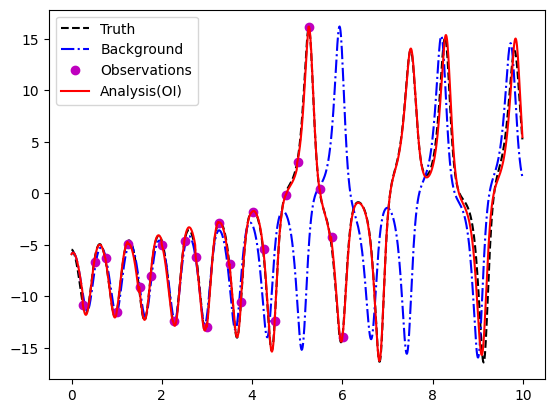

In [30]:
# Plot analysed solution of x

# vec: [  1  26  51  76 101 126 151 176 201 226 251 276 301 326 351 376 401 426 451 476 501 526 551 576 601]
# v:  [0.26 0.51 0.76 1.01 1.26 1.51 1.76 2.01 2.26 2.51 2.76 3.01 3.26 3.51 3.76 4.01 4.26 4.51 4.76 5.01 5.26 5.51 5.76 6.01]
# xob:  [-10.65301222  -6.402435    -6.6320839  -11.49329881  -4.30745203  -9.60500637  -8.3607356   -4.68791933 -12.90259201  -5.28373177  -5.20754124 -12.76142362  -3.21719201  -7.06068812 -10.99890773  -1.72516215  -5.26846882 -12.72512642   0.46696709   2.8736048  16.31688695   0.1410631   -4.2949786  -14.39681102]

plt.figure()

plt.plot(q, x, 'k--', label="Truth")
plt.plot(q, xb, 'b-.', label="Background")
plt.plot(v[1:], xob[vec[1:] - 1], 'om', label='Observations')

if l_assim == 0:
    plt.plot(q, x_sc[0, :], 'r-', label="Analysis(SC)")
elif l_assim == 1:
    plt.plot(q, x_oi[0, :], 'r-', label="Analysis(OI)")
elif l_assim == 2:
    plt.plot(q, x_ac[0, :], 'r-', label="Analysis(AC)")
elif l_assim == 3:
    plt.plot(q, x_kf[0, :], 'r-', label="Analysis(FK)")

plt.legend()
#plt.legend(["Truth", "Background", "Observations", "Analysis"])

ymin, ymax = plt.ylim()
yspace = (ymax - ymin) * 0.01
yvals = np.arange(ymin, ymax, yspace)
xval = (tmax - ob_f) * h
# plt.axvline(x=xval, linestyle=':', color='k')  # Comentado conforme o código original

plt.savefig('x_results.png', dpi=240)
plt.show()

### Plot analysed solution of z

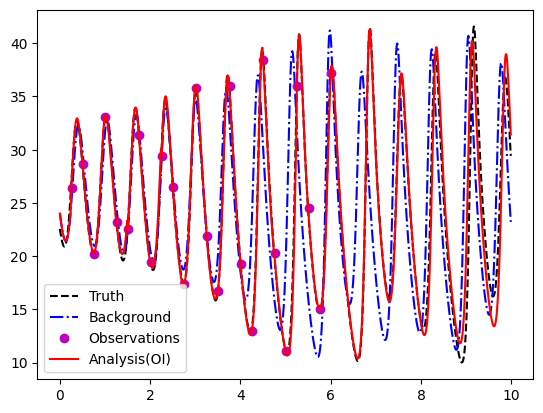

In [31]:
# Plot analysed solution of z

plt.figure()

plt.plot(q, z, 'k--', label="Truth")
plt.plot(q, zb, 'b-.', label="Background")
plt.plot(v[1:], zob[vec[1:] - 1], 'om', label='Observations')

if l_assim == 0:
    plt.plot(q, x_sc[2, :], 'r-', label="Analysis(SC)")
elif l_assim == 1:
    plt.plot(q, x_oi[2, :], 'r-', label="Analysis(OI)")
elif l_assim == 2:
    plt.plot(q, x_ac[2, :], 'r-', label="Analysis(AC)")
elif l_assim == 3:
    plt.plot(q, x_kf[2, :], 'r-', label="Analysis(KF)")

plt.legend()

ymin, ymax = plt.ylim()
yspace = (ymax - ymin) * 0.01
yvals = np.arange(ymin, ymax, yspace)
xval = (tmax - ob_f) * h
# plt.axvline(x=xval, linestyle=':', color='k')

plt.show()


# **Ploting Error**

### Plot analysis error with and without observation

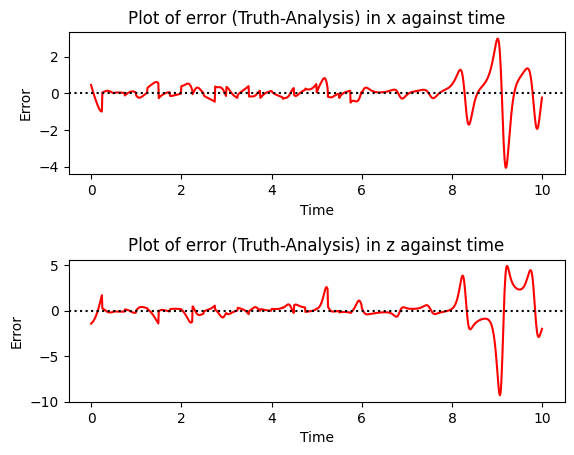

In [32]:
# Calcular os erros com base em l_assim
if l_assim == 0:
    x_err = x - x_sc[0, :]
    z_err = z - x_sc[2, :]
elif l_assim == 1:
    x_err = x - x_oi[0, :]
    z_err = z - x_oi[2, :]
elif l_assim == 2:
    x_err = x - x_ac[0, :]
    z_err = z - x_ac[2, :]
elif l_assim == 3:
    x_err = x - x_kf[0, :]
    z_err = z - x_kf[2, :]

# Plotar os resultados
h3 = plt.figure(3)
plt.clf()

# Subplot 1: Erro em x
plt.subplot(2, 1, 1)
plt.plot(q, x_err, 'r-')
plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Plot of error (Truth-Analysis) in x against time')

# Ajustar limites e adicionar linhas de referência
ymin, ymax = plt.ylim()
yspace = (ymax - ymin) * 0.01
yvals = np.arange(ymin, ymax, yspace)

# Adicionar linha de referência (se necessário)
plt.axhline(y=0, linestyle=':', color='k')

# Subplot 2: Erro em z
plt.subplot(2, 1, 2)
plt.plot(q, z_err, 'r-')
plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Plot of error (Truth-Analysis) in z against time')

# Ajustar limites e adicionar linhas de referência
ymin, ymax = plt.ylim()
yspace = (ymax - ymin) * 0.01
yvals = np.arange(ymin, ymax, yspace)

# Adicionar linha de referência (se necessário)
plt.axhline(y=0, linestyle=':', color='k')

# Ajustar o espaçamento entre os subplots
plt.subplots_adjust(hspace=0.6)

plt.show()

# **Print chosen options**

In [33]:
# Definir variáveis de exemplo (você deve substituir com suas variáveis reais)
#assim_str = "Assimilation Type"
#l_assim = 1
#n_its = 10
#l_weight = 1
#ob_f = 5
#l_noise = 1
#sd = 0.1
#l_read_noise = 0

# Preparar os textos para exibição
text1 = 'List of options chosen:\n'
text2 = f'Analysis scheme: {assim_str}'
text3 = f'Number of iterations: {n_its}' if l_assim == 0 or l_assim == 2 else ''
text4 = 'Using correct weighting matrices' if l_weight != 0 else 'Using incorrect weighting matrices' if l_assim != 0 else ''
text5 = f'Time steps between observations: {ob_f}'
text6 = 'Observations have random noise with variance ' + str(sd) if l_noise != 0 else 'No noise on observations'
text7 = 'Noise generated in program and saved to file' if l_read_noise == 0 else 'Noise read in from previously generated file' if l_noise != 0 else ''

# Exibir os textos
print(text1)
print(text2)
if text3:
    print(text3)
if text4:
    print(text4)
print(text5)
print(text6)
if text7:
    print(text7)

print('\n# # #  END OF PROGRAM  # # #')

List of options chosen:

Analysis scheme: Optimal interpolation
Using correct weighting matrices
Time steps between observations: 25
Observations have random noise with variance 0.1
Noise generated in program and saved to file

# # #  END OF PROGRAM  # # #
